# Create you model wrapper

MMFusion provides an inference script in the `inference.py` file. From this script, we will create a class MMFusion.

In [62]:
import torch
from photoholmes.methods.base import BenchmarkOutput, BaseTorchMethod
from photoholmes.preprocessing import PreProcessingPipeline, ZeroOneRange
import torchvision.transforms.functional as TF

from models.cmnext_conf import CMNeXtWithConf
from models.modal_extract import ModalitiesExtractor
from configs.cmnext_init_cfg import _C as config, update_config


class MMFusion(BaseTorchMethod):

    def __init__(self, exp: str = "experiments/ec_example_phase2.yaml", checkpoint: str = None, device: str = "cpu"):
        super().__init__()
        cfg = update_config(config, exp)

        self.modal_extractor = ModalitiesExtractor(
            cfg.MODEL.MODALS[1:], cfg.MODEL.NP_WEIGHTS
        )
        self.model = CMNeXtWithConf(cfg.MODEL)

        ckpt = torch.load(checkpoint, map_location=device)
        self.model.load_state_dict(ckpt['state_dict'])
        self.modal_extractor.load_state_dict(ckpt["extractor_state_dict"])

        self.eval()

    @torch.no_grad()
    def predict(self, image):
        if image.ndim == 3:
            image = image.unsqueeze(0)

        modals = self.modal_extractor(image)

        images_norm = TF.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        inp = [images_norm] + modals

        anomaly, confidence, detection = self.model(inp)
        
        heatmap = torch.nn.functional.softmax(anomaly, dim=1)[:, 1, :, :].squeeze()

        return heatmap, confidence, detection
    
    def benchmark(self, image) -> BenchmarkOutput:
        heatmap, _, detection = self.predict(image)
        return BenchmarkOutput(heatmap=heatmap, detection=detection, mask=None)


mmfusion_preprocessing = PreProcessingPipeline(
    transforms=[
        ZeroOneRange()
    ],
    inputs=["image"],
    outputs_keys=["image"]
)

In [63]:
method = MMFusion("experiments/ec_example_phase2.yaml", "ckpt/model_zoo/early_fusion_detection.pth")

INFO - Noiseprint++ weights: pretrained/noiseprint/np++.pth
INFO - Currently training for detection
INFO - Loading Model: ec_example_phase2, with backbone: MixCMNeXtMHSA-B2


INFO - Loading pretrained module: pretrained/segformer/mit_b2.pth


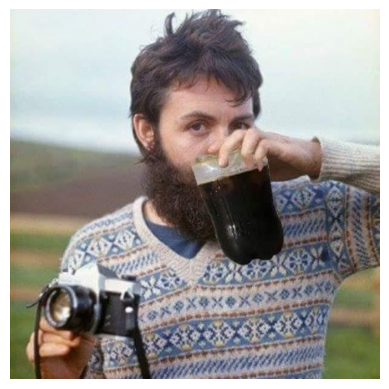

torch.Size([1, 3, 612, 612])

In [59]:
from photoholmes.utils.image import read_image, plot

image = read_image("data/paul_cvpr.jpeg").unsqueeze(0)
plot(image[0])
image.shape

In [60]:
input_data = mmfusion_preprocessing(image=image)
heatmap, conf, detection = method.predict(**input_data)

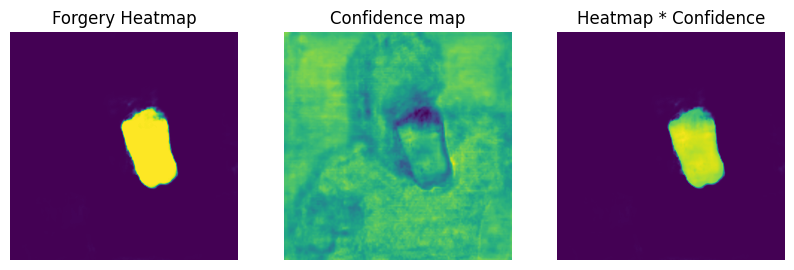

5.158888339996338


In [35]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 20))
plt.subplot(1, 3, 1)
plt.imshow(heatmap.detach().cpu().numpy())
plt.axis("off")
plt.title("Forgery Heatmap")
plt.subplot(1, 3, 2)
plt.imshow(conf.squeeze().detach().cpu().numpy())
plt.axis("off")
plt.title("Confidence map")
plt.subplot(1, 3, 3)
plt.imshow(heatmap.detach().cpu().numpy() * conf.squeeze().detach().cpu().numpy())
plt.axis("off")
plt.title("Heatmap * Confidence")
plt.subplot(1, 3, 3)
plt.show()
print(detection.item())

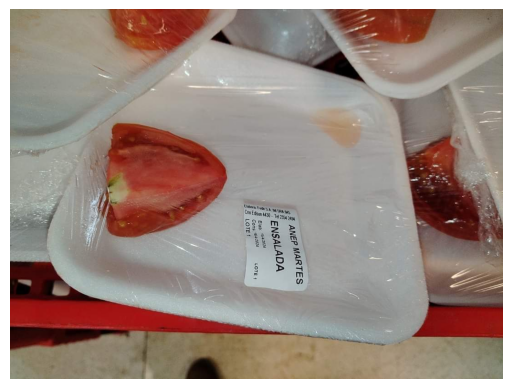

torch.Size([1, 3, 810, 1080])

In [41]:
from photoholmes.utils.image import read_image, plot

image = read_image("data/tomate.jpg").unsqueeze(0)
plot(image[0])
image.shape

In [42]:
input_data = mmfusion_preprocessing(image=image)
heatmap, conf, detection = method.predict(**input_data)

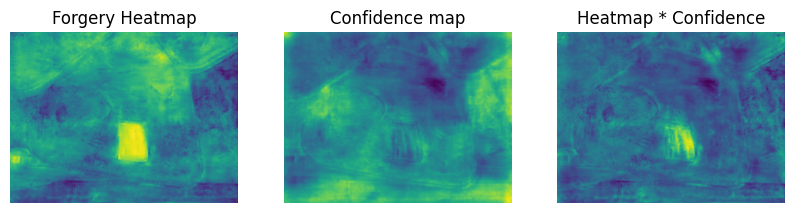

0.3811142146587372


In [43]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 20))
plt.subplot(1, 3, 1)
plt.imshow(heatmap.detach().cpu().numpy())
plt.axis("off")
plt.title("Forgery Heatmap")
plt.subplot(1, 3, 2)
plt.imshow(conf.squeeze().detach().cpu().numpy())
plt.axis("off")
plt.title("Confidence map")
plt.subplot(1, 3, 3)
plt.imshow(heatmap.detach().cpu().numpy() * conf.squeeze().detach().cpu().numpy())
plt.axis("off")
plt.title("Heatmap * Confidence")
plt.subplot(1, 3, 3)
plt.show()
print(detection.item())

In [48]:
from photoholmes.datasets.columbia import ColumbiaDataset

datasets = ColumbiaDataset(
    "data/Columbia",
    load=["image"],
    preprocessing_pipeline=mmfusion_preprocessing
)

In [50]:
from photoholmes.metrics import F1Score, MCC

metrics = [F1Score(), MCC()]

In [51]:
from photoholmes.benchmark import Benchmark

benchmark = Benchmark(
    device="cpu"
)

In [64]:
benchmark.run(
    method=method,
    dataset=datasets,
    metrics=metrics
)

INFO - Using device: cpu
INFO - --------------------------------------------------------------------------------
INFO - --------------------------------------------------------------------------------
INFO - Running the benchmark
INFO - --------------------------------------------------------------------------------
INFO - --------------------------------------------------------------------------------
INFO - Benchmark configuration:
INFO -     Method: MMFusion
INFO -     Dataset: ColumbiaDataset
INFO -     Metrics:
INFO -        - BinaryF1Score
INFO -        - BinaryMatthewsCorrCoef
INFO -     Output path: output/mmfusion/columbiadataset
INFO -     Save method outputs: True
INFO -     Save metrics: True
INFO -     Device: cpu
INFO -     Load existing outputs: True
INFO -     Verbosity: INFO
INFO - --------------------------------------------------------------------------------
INFO - --------------------------------------------------------------------------------
Processing Images:   

KeyboardInterrupt: 